In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import re
import nltk
import inflect


import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

# Read Train Split and Validation Data

In [2]:
rev_busi_Philly= pd.read_csv('filtered_reviews_in_Philly.csv', parse_dates=["date"])

train_df  = pickle.load(open('train_df.pkl', "rb"))
valid_df = pickle.load(open('valid_df.pkl', "rb"))
test_df = pickle.load(open('test_df.pkl', "rb"))

In [3]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(305742, 3)
(25920, 3)
(25920, 3)


In [46]:
train_df = train_df.merge(rev_busi_Philly[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
valid_df = valid_df.merge(rev_busi_Philly[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi_Philly[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])

train_df.head(1)

,user_id,business_id,stars,review_id_x,text_x,review_id_y,text_y
0,--2tyArRmSoyKx5r-FVG0A,IXRSMV7U5D0sYJvArEbm5g,3.0,h6uBPOzXO2pI7JOOi_9vlQ,Frequented this spot quite a bit all through o...,h6uBPOzXO2pI7JOOi_9vlQ,Frequented this spot quite a bit all through o...


In [5]:
train_df.shape
valid_df.shape
test_df.shape
rev_busi_Philly.shape

(305742, 5)

(25920, 5)

(25920, 5)

(357582, 11)

In [6]:
print("unique users in training set:", train_df["user_id"].nunique())
print("unique businesses in training set:", train_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 26205
unique businesses in training set: 2523
unique users in test set: 25920
unique businesses in test set: 2453


# Content-based Model, NLP (Tf-idf)

### - Combine reviews of each business_id as its document 

In [7]:
train_df.head(1)
text_train_df = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()

# len(text_train_df)
# text_train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2tyArRmSoyKx5r-FVG0A,IXRSMV7U5D0sYJvArEbm5g,3.0,h6uBPOzXO2pI7JOOi_9vlQ,Frequented this spot quite a bit all through o...


In [8]:
text_train_df.head()

,business_id,text
0,-0TffRSXXIlBYVbb5AwfTg,FINALLY got to try out this (not-so) new India...
1,-1B9pP_CrRBJYPICE5WbRA,"Folks, as a certified fire eater, there aren't..."
2,-2-ih3mE8KPyeKVIzpBfPQ,"Wow, I had no idea this place existed, but its..."
3,-32hOCwsuKd04WO-HQyYFg,Decent Italian/American food. Nothing to flip ...
4,-5Rah4ZvWsDu4oilUZxhtw,Try the Shrimp and Grits. Great Music and Perf...


### - Generate Wordcloud

<Figure size 1000x1000 with 0 Axes>

(-0.5, 5999.5, 5999.5, -0.5)

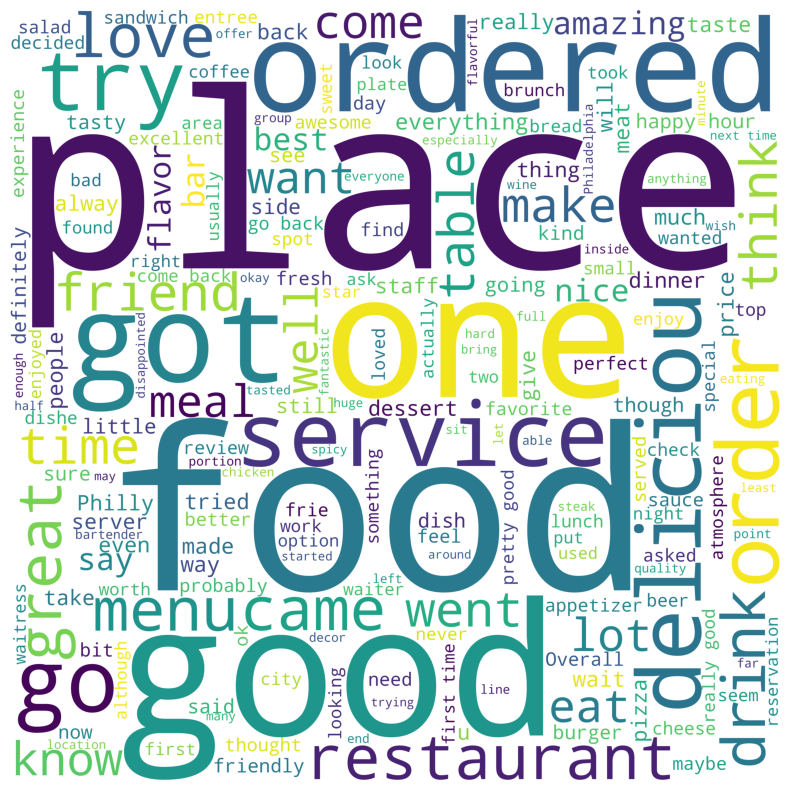

In [9]:
# gather all words together
all_text = ""
all_snippets = text_train_df["text"].values

for snippet in all_snippets:
    all_text += snippet

# plot Wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### - Text Prepocessing

In [28]:
#### ONLY USE ONCE FOR DOWNLOADING NLTK##
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
            
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
            
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
        
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
        
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
        
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words


In [11]:
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    #new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        #new_texts.append(text)
        processed = pd.concat([processed, dfnew],ignore_index = True)

    return processed

In [12]:
### PICKLE THIS FOR FASTER PROCESSING

df_texts_train = get_processed(text_train_df)
df_texts_train.to_pickle('text_train_df.pkl')

#df_texts_train = pickle.load(open('../data/text_train_df.pkl', "rb"))


In [13]:
text_train_df.head()

,business_id,text
0,-0TffRSXXIlBYVbb5AwfTg,FINALLY got to try out this (not-so) new India...
1,-1B9pP_CrRBJYPICE5WbRA,"Folks, as a certified fire eater, there aren't..."
2,-2-ih3mE8KPyeKVIzpBfPQ,"Wow, I had no idea this place existed, but its..."
3,-32hOCwsuKd04WO-HQyYFg,Decent Italian/American food. Nothing to flip ...
4,-5Rah4ZvWsDu4oilUZxhtw,Try the Shrimp and Grits. Great Music and Perf...


In [14]:
df_texts_train.head()

,business_id,text
0,-0TffRSXXIlBYVbb5AwfTg,final get tri notso new indian spot everyon ra...
1,-1B9pP_CrRBJYPICE5WbRA,folk certifi fire eater nt ton place weapon gr...
2,-2-ih3mE8KPyeKVIzpBfPQ,wow idea place exist cool nice hangout top one...
3,-32hOCwsuKd04WO-HQyYFg,decent italianamerican food noth flip lid pizz...
4,-5Rah4ZvWsDu4oilUZxhtw,tri shrimp grit great music perform happi hour...


### - Cosine Similarity

In [15]:
def get_tfidf_matrix(processed):
    '''
    get the Tf-Idf matrix of processed texts for business reviews
    
    '''
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    '''
    use truncated SVD to reduce dimensionality
    '''
    SVD = TruncatedSVD(n_components = n , random_state = 42) 
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    
    return cosine_sim


### - Dimension Reduction

(2523, 230479)
(2522,)
24.05716547045422


<BarContainer object of 2522 artists>

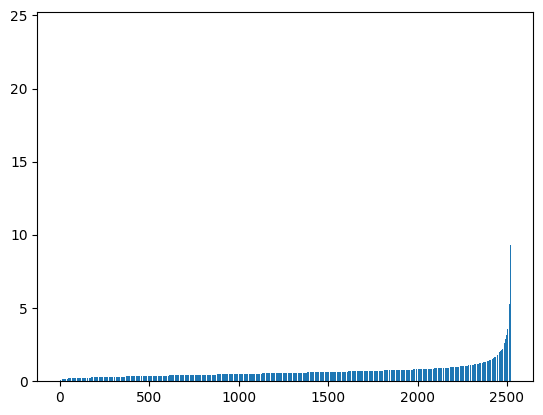

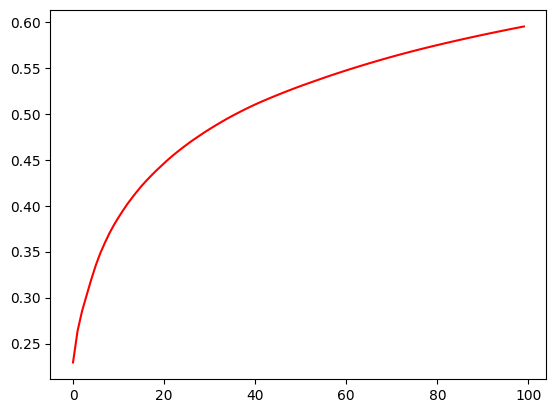

In [16]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
print(tfidf_matrix.shape)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
print(s.shape)
print(s[-1])
plt.bar(range(len(s)),s)
plt.show()

plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )
plt.show()

Text(0.5, 0, 'Number of Components')

Text(0, 0.5, 'Cumulative Explained Variance')

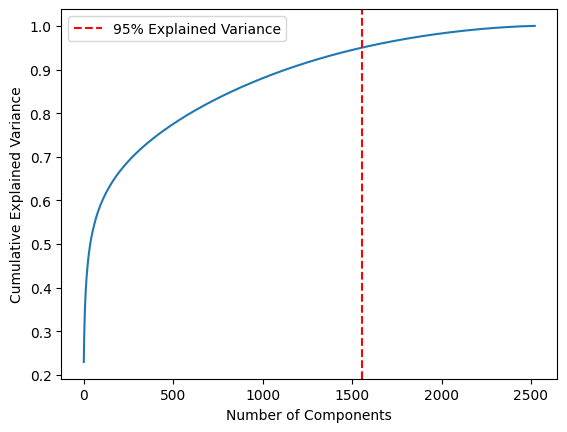

In [28]:
# Sort singular values in descending order
s_sorted = np.flip(s)
explained_variance = np.square(s_sorted) / np.sum(np.square(s_sorted))
cumulative_explained_variance = np.cumsum(explained_variance) / np.sum(explained_variance)
index_95_percent = np.argmax(cumulative_explained_variance >= 0.95) ### threshold set to 95 percent  .... 

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=index_95_percent, color='red', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

### - Here we choose n=1500

In [29]:
### Generate Tf-idf vector space representation, and apply truncated SVD

tfidf_matrix = get_tfidf_matrix(df_texts_train)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 1500)
df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'].values, columns=df_texts_train['business_id'].values)
df_sim.head(1)
cosine_sim.shape

,-0TffRSXXIlBYVbb5AwfTg,-1B9pP_CrRBJYPICE5WbRA,-2-ih3mE8KPyeKVIzpBfPQ,-32hOCwsuKd04WO-HQyYFg,-5Rah4ZvWsDu4oilUZxhtw,-6nQZ-QCkAyNHdtaxOxDpQ,-ATiAtTikuGuqvaW2O6tNA,-AanHawaDlzWHQjrqRRWig,-Ah-gbZpa-IiQVIrhKRhhA,-BLVl824WRLFIm_uiHmkbA,...,zpKTPWoW56wF6d9qNnxM3Q,zrQAj03aHI7kpmAiyKcKhA,zropQGh2fc7PMpzd32vneQ,zssISv4ZdplRT_Zcw8drPQ,zuEdIZKAYBDfPjyFg6B34Q,zucC7rHpXPYBu7aEqj0NUw,zujdPV3HT-Y-CKE1GgkMHQ,zwTmOj4B_OVPMTMYijQiKg,zwd4dyQ5ovnjVojWfAuhMw,zwgBxmrmPBF6N2uRTUYXrQ
-0TffRSXXIlBYVbb5AwfTg,1.0,0.48067,0.194396,0.20304,0.275446,0.189235,0.39277,0.215966,0.208786,0.25862,...,0.215846,0.305118,0.187407,0.318346,0.271746,0.307881,0.175778,0.24753,0.258792,0.21398


(2523, 2523)

In [30]:
'''

THiis function calculated similarity of all the restaruratns reviewed by a user to the specified business id, and then chooses the top k based on similarity
'''
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
    '''get the business_id_array that shows top_k greatest similarity to the specific business_id'''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]  ### extracts only those business that have value in the similarity matrix for this business ID, and those business that the user has actually visited
    ### , in the df_user_df, we only extract column name, which is equal to the businessID = business_id
    
    
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    
    return np.array(df_user_topk.index.values)


def predict_rating(reviews, user_id, business_ids):
    '''predict the avg of the user's rating on business in business_ids'''
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    
    return np.mean(scores)


def get_results_cos(reviews, reviews_test, business_id, user_id, df_sim, k):
    '''
    prediction on the business_id：avg the ratings on top_k business that shows similarity to the business_id
    actual on the business_id: the true rating 
    '''
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0] ### why is this values[0] ????
    business_ids = get_recommendation_cos(reviews, business_id, user_id, df_sim, k)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

def get_review_processed(processed, reviews):
    
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                                                       .reset_index()\
                                                       .drop(columns=['index'])
    return reviews_processed

'\n\nTHiis function calculated similarity of all the restaruratns reviewed by a user to the specified business id, and then chooses the top k based on similarity\n'

In [31]:
### train_df has all the business, and the users.
###
print(train_df.shape)

reviews_processed = get_review_processed(df_texts_train, train_df)
reviews_processed.head()
print(reviews_processed.shape)

(305742, 5)


,user_id,business_id,stars,review_id,text
0,--2tyArRmSoyKx5r-FVG0A,IXRSMV7U5D0sYJvArEbm5g,3.0,h6uBPOzXO2pI7JOOi_9vlQ,Frequented this spot quite a bit all through o...
1,--2tyArRmSoyKx5r-FVG0A,eoN0GAIRV0WmwUm7FmzKgQ,4.0,tOZmaUmY4YiTw9s7CWpH4w,The first time I visited Yakitori Boy I must s...
2,--2tyArRmSoyKx5r-FVG0A,vXb4OWsjPoiBtmarfexj-g,4.0,97TbJlDqcRyMbh_nSCG_QQ,Visited the highly acclaimed vastly recommende...
3,--4AjktZiHowEIBCMd4CZA,EtKSTHV5Qx_Q7Aur9o4kQQ,4.0,J01H6SuqtTwJOJ1kf91srA,"I love Village Whiskey, it's just a shame it's..."
4,--4AjktZiHowEIBCMd4CZA,OLkS4jfozQpUIUq0K6t_IQ,3.0,dfiekXW_4nhWYfC4XO-i4Q,"The hot dogs were good, as were the fries and ..."


(305742, 5)


In [32]:
def CB_predict(reviews, reviews_test, df_sim, k = 5):
    '''
    based on test_df 
    get a dataframe with each user on each business's true ratings and prediction ratings
    @k: int, top k similar businesses
    '''
    user_id_sample = reviews_test['user_id'].values
    busi_id_sample = reviews_test['business_id'].values
    
    actual = []
    predictions = []
    
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, busi_id_sample[i], user_id_sample[i], df_sim, k)
            actual.append(act)
            predictions.append(pred)
            
        except:
            actual.append(np.nan)
            predictions.append(np.nan)
            
    return pd.DataFrame({"user_id": user_id_sample,
                         "business_id": busi_id_sample,
                         "true_ratings": actual,
                         "prediction_ratings":  predictions                        
                        })

In [33]:
valid_df.head()
valid_df.shape

,user_id,business_id,stars,review_id,text
0,--2tyArRmSoyKx5r-FVG0A,jHZS9GIhW7s9r4w5w-0A0Q,3.0,XjFVbiI3xleZMEV57wzDQg,Have been living in the Northern Liberties are...
1,--4AjktZiHowEIBCMd4CZA,eXKblEHP3YJYU1Awz08hVw,5.0,tT3kkrTc1QzLXKecHOX8ZA,This truck has some of the tastiest tacos and ...
2,--ccVMj2PN6Z9qtdOdlung,bSWL0YxfawjS03_g2kgujA,3.0,EYHkDtJuleyioRX0wxEv7g,"I've never actually been into Allegro, because..."
3,--pMssoWlOqX0pLiPMiZZw,J8S7cPPlTgsQnXKVfTyN8g,4.0,vhDiXogSAG305p8K11fzRA,"PYT, you have redeemed yourself. We had some f..."
4,-02tzlpQosZ9HE85jEtV6Q,-KWel73upKHxstRCr9JGLw,2.0,KLcErQGGq01dA3Eoz_SjJw,I came In 1 day for a bite to eat. Sat by the ...


(25920, 5)

### - Tuning parameters k

'\n        Here we do the processing in batches, where in every batch, we choose a sample from the validation set, use it\n        to observe what value of K work best.\n        '

/var/folders/rk/5qrwfd812f94v60p04y5t27m0000gn/T/ipykernel_32682/2852288665.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred_results = pd.concat([df_pred_results, pd.DataFrame({"ks": k, "sample_size": sample_size,


time elapsed: (seconds)
7825.034


<Axes: xlabel='ks'>

optimal k (nearest neighbors):
   ks sample_size      rmse       mae
5  55       25920  1.248472  0.976352


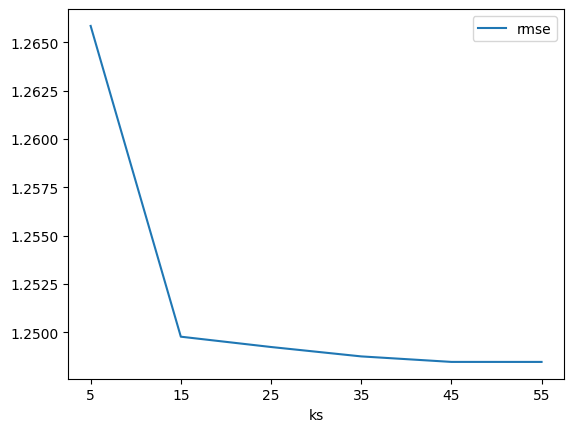

In [34]:



t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5, 15, 25, 35, 45, 55]
'''
        Here we do the processing in batches, where in every batch, we choose a sample from the validation set, use it
        to observe what value of K work best.
        '''
for sample_size in sample_sizes:
    for k in ks:
        ### do this for every batch
        
        valid = CB_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        df_pred_results = pd.concat([df_pred_results, pd.DataFrame({"ks": k, "sample_size": sample_size,
                                                  "rmse": rmse, "mae": mae}, index = [0])], ignore_index = True)
        
        
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),])

# df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

In [37]:
df_pred_results.head()
df_pred_results.info()


,ks,sample_size,rmse,mae
0,5,25920,1.265843,0.981731
1,15,25920,1.249777,0.977225
2,25,25920,1.249244,0.976935
3,35,25920,1.248758,0.976587
4,45,25920,1.248473,0.976363


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ks           6 non-null      object 
 1   sample_size  6 non-null      object 
 2   rmse         6 non-null      float64
 3   mae          6 non-null      float64
dtypes: float64(2), object(2)
memory usage: 320.0+ bytes


In [36]:
df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

In [38]:
### Prediction using the tuned parameters

t0 = time.time()
k = 55

valid = CB_predict(train_df, test_df, df_sim, k)
mse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))
print(mse)
valid.to_csv("Predictions_CB_tfidf.csv", index = False)




time elapsed: (seconds)
1135.286
1.6938441073237547


In [45]:
print(valid.head())

                  user_id             business_id  true_ratings  \
0  --2tyArRmSoyKx5r-FVG0A  L3V21nAe-CicW2bvtNWa0g           2.0   
1  --4AjktZiHowEIBCMd4CZA  Yz0fJyBkUF8VZBvwFswkRQ           5.0   
2  --ccVMj2PN6Z9qtdOdlung  9ggTidLF9LPNdyWdCGtrYg           5.0   
3  --pMssoWlOqX0pLiPMiZZw  9e_rrzyTolsH1RUXHOvsMA           3.0   
4  -02tzlpQosZ9HE85jEtV6Q  o996tDYd0KRgeuY9mDeAGg           4.0   

   prediction_ratings  
0            3.666667  
1            4.000000  
2            3.166667  
3            3.625000  
4            4.250000  
